In [3]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1 task

In [4]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [5]:
class NLLLoss(torch.nn.Module):
    
    def __init__(self):
        super(NLLLoss, self).__init__()
    
    def forward(self, x):
        return -torch.mean(torch.log(x))
    
class LikelihoodModel(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LikelihoodModel, self).__init__()
        self.theta = torch.nn.Parameter(torch.zeros(100))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
#         top = np.exp(theta[x])
#         bottom = 0
#         for theta_i in theta:
#             bottom += np.exp(theta_i)
        return torch.exp(self.theta[x]) / torch.sum(torch.exp(self.theta))

In [6]:
data = sample_data()

In [7]:
X_train_val, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.2, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (6400,), X_val shape: (1600,), X_test shape: (2000,)


In [8]:
bsize = 1000
trainloader=torch.utils.data.DataLoader(X_train, batch_size=bsize, shuffle=True, num_workers=3)
testloader=torch.utils.data.DataLoader(X_val, batch_size=bsize, shuffle=False, num_workers=3)

In [9]:
n_epochs = 1000
lr=0.001

model = LikelihoodModel()
loss_function = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    train_loss_sum = 0
    n_train_batch = len(trainloader)
    model.train()
    for data in trainloader:
        optimizer.zero_grad()
        inputs = data
        outputs = model(inputs)
        loss = loss_function(outputs)
        train_loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    test_loss_sum = 0
    n_test_batch = len(testloader)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs = data
            outputs = model(inputs)
            loss = loss_function(outputs)
            test_loss_sum += loss.item()
    print(f'\r epoch: [{epoch+1}/{n_epochs}], loss: {np.round(train_loss_sum / n_train_batch, 2)}, test_loss: {np.round(test_loss_sum / n_test_batch, 2)}', end='')
    train_losses.append(train_loss_sum / n_train_batch)
    test_losses.append(test_loss_sum / n_test_batch)

 epoch: [1000/1000], loss: 4.04, test_loss: 4.0

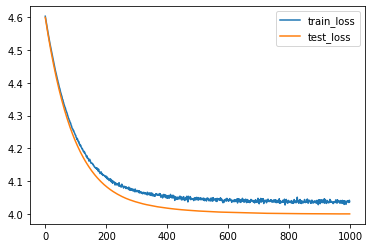

In [17]:
plot_size = n_epochs
plt.plot(list(range(plot_size)), train_losses, label='train_loss')
plt.plot(list(range(plot_size)), test_losses, label='test_loss')
plt.legend()
plt.show()

In [37]:
plot_size = 100
pred = model(torch.arange(plot_size)).tolist()
pred = np.array(pred) * 1500
data = np.zeros(plot_size)
for x in testloader.dataset:
    data[x] += 1

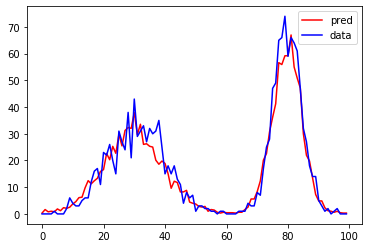

In [38]:
plt.plot(list(range(plot_size)), pred, color='r', label='pred')
plt.plot(list(range(plot_size)), data, color='b', label='data')
plt.legend()
plt.show()

# 2 Task

### 1

In [39]:
distribution = np.load('./distribution.npy')

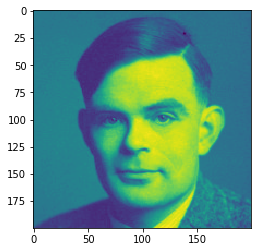

In [50]:
plt.imshow(distribution)

In [69]:
distribution.size

40000

In [74]:
sample % 200

array([ 66,  47,  78, ..., 117, 156,  90])

In [91]:
n_sample = 100000
domain = distribution.size
axes_len = np.sqrt(domain)
sample = np.random.choice(domain, size=n_sample, p=distribution.ravel())
x1 = sample % 200
x2 = sample // 200

data = []
for ax1, ax2 in zip(x1, x2):
    data.append([ax1, ax2])
data = np.array(data)

In [93]:
X_train_val, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.2, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (64000, 2), X_val shape: (16000, 2), X_test shape: (20000, 2)


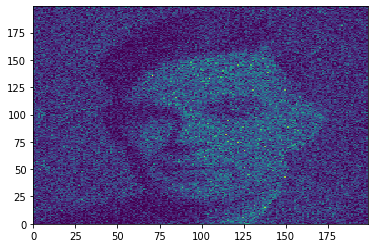

In [95]:
plt.hist2d(x1, 199 - x2, bins=200)
plt.show()

In [63]:
distribution

array([[2.2155111e-05, 2.1582135e-05, 2.1773127e-05, ..., 1.9290226e-05,
        1.9481218e-05, 1.9290226e-05],
       [2.1200151e-05, 2.1773127e-05, 2.1964119e-05, ..., 1.9290226e-05,
        1.9672212e-05, 1.9672212e-05],
       [2.1964119e-05, 2.1964119e-05, 2.2155111e-05, ..., 1.8908242e-05,
        1.9290226e-05, 1.9481218e-05],
       ...,
       [2.0054196e-05, 1.9672212e-05, 1.8335264e-05, ..., 1.7762288e-05,
        1.8144272e-05, 1.3942441e-05],
       [1.8526258e-05, 1.7571296e-05, 1.6043357e-05, ..., 1.7762288e-05,
        1.7762288e-05, 1.6425342e-05],
       [1.6807326e-05, 1.5279387e-05, 1.3942441e-05, ..., 2.0054196e-05,
        1.7762288e-05, 2.1964119e-05]], dtype=float32)

In [102]:
class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        n = 200
        a = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.ReLU(), torch.nn.Dropout())
        b = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.ReLU(), torch.nn.Dropout())
        c = torch.nn.Sequential(torch.nn.Linear(n, n), torch.Softmax(dim=1))
        self.layers = torch.nn.Sequential(a, b, c)
        
    def forward(self, x):
        return self.layers(x)

In [105]:
class TaskModel(torch.nn.Module):
    
    def __init__(self):
        super(TaskModel, self).__init__()
        self.likelihood_model = LikelihoodModel()
        self.mlp = MLP()
        
    def forward(self, x):
        ax1 = x[:,0]
        ax2 = x[:,1]
        pred_x1 = self.likelihood_model(ax1)
        pred_x2 = None
        return pred_x1 * pred_x2

### 2

In [107]:
class MaskedLinear(torch.nn.Linear):
    
    def __init__(self, in_d, out_d, mask):
        super(MaskedLinear, self).__init__(in_d, out_d, False)
        self.mask = mask
        
    def forward(self, x):
        return torch.nn.functional.linear(x, self.weight * self.mask)
        

In [108]:
class MADE(torch.nn.Module):
    
    def __init__(self):
        super(MADE, self).__init__()

    def forward(self, x):
        return None